In [ ]:
# https://sharmaabhishekk.github.io/projects/passmap

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pandas import json_normalize
import numpy as np

import warnings

In [4]:
match_id = "3788741"#"18240"#"3788741"#"8658"
side = "away"
color = "blue"
min_pass_count = 2 ##minimum number of passes for a link to be plotted

In [5]:
class Player:
    def __init__(self, player, df):
        self.id = player["player"]["id"]
        self.name = player["player"]["name"]
        self.average_position(df)

    def average_position(self, df):

        player_pass_df = df.query("(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & (player_id == @self.id) & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
        self.x, self.y = np.mean(player_pass_df['location'].tolist(), axis=0)

        self.n_passes_completed = len(player_pass_df)

def load_file(match_id, getter="remote", path = None):
    """ """

    if getter == "local":
        with open(f"{path}/{match_id}.json", "r", encoding="utf-8") as f:
            match_dict = json.load(f)
            df = json_normalize(match_dict, sep="_")
            df = df.query("location == location")
            df[['x','y']] = pd.DataFrame(df.location.values.tolist(), index= df.index)
            df['y'] = 80 - df['y'] ##Reversing the y-axis co-ordinates because Statsbomb use this weird co-ordinate system
            df['location'] = df[['x', 'y']].apply(list, axis=1)

        return match_dict, df

    elif getter == "remote":
        resp = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json")

        match_dict = json.loads(resp.text)
        df = json_normalize(match_dict, sep="_")
        df = df.query("location == location")
        df[['x','y']] = pd.DataFrame(df.location.values.tolist(), index= df.index)
        df['y'] = 80 - df['y'] ##Reversing the y-axis co-ordinates because Statsbomb use this reversed co-ordinate system
        df['location'] = df[['x', 'y']].apply(list, axis=1)

        return match_dict, df


def get_starters(match_dict, side="home"):
    """ """
    lineups = match_dict[0]["tactics"]["lineup"] if side == "home" else match_dict[1]["tactics"]["lineup"]
    return lineups

In [6]:
match_dict, df = load_file(match_id)
lineups = get_starters(match_dict, side=side)

/tmp/ipykernel_189271/4255123304.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x','y']] = pd.DataFrame(df.location.values.tolist(), index= df.index)
/tmp/ipykernel_189271/4255123304.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['x','y']] = pd.DataFrame(df.location.values.tolist(), index= df.index)
/tmp/ipykernel_189271/4255123304.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [7]:
side_dict = {"home": match_dict[0]["team"]["name"],
             "away": match_dict[1]["team"]["name"] }
side_dict

{'home': 'Turkey', 'away': 'Italy'}

In [8]:
player_objs_dict = {}
starters = []
for player in lineups:
    starters.append(player["player"]["name"]) ##To remove all substitutes from our final grouped_df
    p = Player(player, df) ##Calling the Player class
    player_objs_dict.update({player["player"]["name"]: p}) ##For lookup during plotting the grouped_df


In [9]:
total_pass_df = df.query(f"(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) &"\
                                 f"(team_name == '{side_dict[side]}') & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")

total_pass_df = total_pass_df.groupby(["player_name", "pass_recipient_name"]).size().reset_index(name="count")

total_pass_df = total_pass_df.query(" (player_name == @starters) & (pass_recipient_name == @starters) & (count>=@min_pass_count) ")

In [10]:
lineup_df = json_normalize(lineups, sep='_')[['player_name', 'jersey_number']]

In [11]:
lineup_df

,player_name,jersey_number
0,Gianluigi Donnarumma,21
1,Alessandro Florenzi,24
2,Leonardo Bonucci,19
3,Giorgio Chiellini,3
4,Leonardo Spinazzola,4
5,Jorge Luiz Frello Filho,8
6,Nicolò Barella,18
7,Manuel Locatelli,5
8,Domenico Berardi,11
9,Lorenzo Insigne,10


In [10]:
total_pass_df = total_pass_df.merge(lineup_df,
                                    on="player_name",
                                    how='left')

total_pass_df = total_pass_df.merge(lineup_df,
                                    left_on='pass_recipient_name',
                                    right_on="player_name",
                                    how='left', )

In [12]:
total_pass_df.columns = ['player_name', 'pass_recipient_name', 'count',
                         'player_number', 'pass_recipient_name_y', 'pass_recipient_number']
total_pass_df = total_pass_df[['player_name', 'pass_recipient_name', 'count',
                               'player_number', 'pass_recipient_number']]

In [16]:
total_pass_df.sort_values(by='count', ascending=False)

,player_name,pass_recipient_name,count,player_number,pass_recipient_number
45,Leonardo Spinazzola,Lorenzo Insigne,19,4,10
36,Leonardo Bonucci,Giorgio Chiellini,18,19,3
22,Giorgio Chiellini,Leonardo Bonucci,16,3,19
56,Manuel Locatelli,Giorgio Chiellini,15,5,3
23,Giorgio Chiellini,Leonardo Spinazzola,15,3,4
...,...,...,...,...,...
39,Leonardo Bonucci,Nicolò Barella,2,19,18
40,Leonardo Spinazzola,Ciro Immobile,2,4,17
13,Domenico Berardi,Manuel Locatelli,2,11,5
44,Leonardo Spinazzola,Jorge Luiz Frello Filho,2,4,8


In [17]:
import networkx as nx
from unidecode import unidecode

In [18]:
G = nx.DiGraph()

edges = [(int(row['player_number']), int(row['pass_recipient_number'])) for i, row in total_pass_df.iterrows()]
weights = [int(row['count']) for i, row in total_pass_df.iterrows()]


for i in range(len(edges)):
    G.add_edge(edges[i][0],edges[i][1], weight=weights[i])

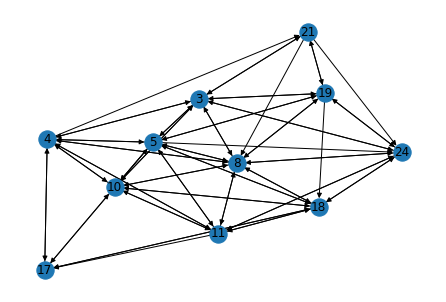

In [19]:
nx.draw(G,
        with_labels=True)
#Fixar as posições pra entender melhor
# melhorar esse grafico

#https://www.youtube.com/watch?v=6eQOBuvUPeg


In [32]:
lineup_df

,player_name,jersey_number
0,Gianluigi Donnarumma,21
1,Alessandro Florenzi,24
2,Leonardo Bonucci,19
3,Giorgio Chiellini,3
4,Leonardo Spinazzola,4
5,Jorge Luiz Frello Filho,8
6,Nicolò Barella,18
7,Manuel Locatelli,5
8,Domenico Berardi,11
9,Lorenzo Insigne,10


In [20]:
pr = nx.pagerank(G,)
pr

{24: 0.08280359792914127,
 11: 0.09108445206492699,
 3: 0.1298233892418582,
 8: 0.12344991185836174,
 19: 0.07658974174986886,
 18: 0.11460871714470931,
 17: 0.04220750029841365,
 4: 0.09272465878105748,
 10: 0.11732348288213355,
 5: 0.09411513666166288,
 21: 0.03526941138786609}

In [21]:
print(f"Jogador com maior grau ->{max(G.degree(), key=lambda x: x[1])}")
print(f"Jogador com menor grau ->{min(G.degree(), key=lambda x: x[1])}")
print(f"Média de grau ->{sum(dict(G.degree()).values())/len(G.nodes())}")
print(f"Desvio padrão de grau ->{np.std(list(dict(G.degree()).values()))}")
print()
print(f"Jogador com maior grau de entrada ->{max(G.in_degree(), key=lambda x: x[1])}")
print(f"Jogador com menor grau de entrada ->{min(G.in_degree(), key=lambda x: x[1])}")
print(f"Média de grau de entrada ->{sum(dict(G.in_degree()).values())/len(G.nodes())}")
print(f"Desvio padrão de grau de entrada ->{np.std(list(dict(G.in_degree()).values()))}")
print()
print(f"Jogador com maior grau de saída ->{max(G.out_degree(), key=lambda x: x[1])}")
print(f"Jogador com menor grau de saída ->{min(G.out_degree(), key=lambda x: x[1])}")
print(f"Média de grau de saída ->{sum(dict(G.out_degree()).values())/len(G.nodes())}")
print(f"Desvio padrão de grau de saída ->{np.std(list(dict(G.out_degree()).values()))}")
print()
print(f"Jogadores com grau de entrada acima da média ->{[x for x in G.nodes()if G.in_degree(x)>sum(dict(G.in_degree()).values())/len(G.nodes())]}")
print(f"Jogadores com grau de saída acima da média ->{[x for x in G.nodes() if G.out_degree(x)>sum(dict(G.out_degree()).values())/len(G.nodes())]}")

Jogador com maior grau ->(8, 17)
Jogador com menor grau ->(17, 7)
Média de grau ->12.363636363636363
Desvio padrão de grau ->2.9931050242098776

Jogador com maior grau de entrada ->(8, 9)
Jogador com menor grau de entrada ->(21, 3)
Média de grau de entrada ->6.181818181818182
Desvio padrão de grau de entrada ->1.5850541612875175

Jogador com maior grau de saída ->(5, 9)
Jogador com menor grau de saída ->(17, 3)
Média de grau de saída ->6.181818181818182
Desvio padrão de grau de saída ->1.6414063713879807

Jogadores com grau de entrada acima da média ->[24, 3, 8, 18, 10, 5]
Jogadores com grau de saída acima da média ->[11, 3, 8, 4, 5]


## Clusterização

In [33]:
#Fazer a clusterização global 

## verificar existencia de linha de passe e distância entre eles- voronoff?
### ler sobre expected passes

In [22]:
print(f"Jogadores com maior clusterização -> {max(nx.clustering(G), key=lambda x: nx.clustering(G)[x])}")
print(f"Jogadores com menor clusterização -> {min(nx.clustering(G), key=lambda x: nx.clustering(G)[x])}")
print(f"Média de clusterização -> {nx.average_clustering(G)}")
print(f"Desvio padrão de clusterização -> {np.std(list(nx.clustering(G).values()))}")
print()
print(f"Jogadores com maior centralidade de proximidade -> {max(nx.closeness_centrality(G), key=lambda x: nx.closeness_centrality(G)[x])}")
print(f"Jogadores com menor centralidade de proximidade -> {min(nx.closeness_centrality(G), key=lambda x: nx.closeness_centrality(G)[x])}")
print(f"Média de centralidade de proximidade -> {sum(nx.closeness_centrality(G).values())/len(G.nodes())}")
print(f"Desvio padrão de centralidade de proximidade -> {np.std(list(nx.closeness_centrality(G).values()))}")
print()
print(f"Jogadores com maior centralidade de intermediário -> {max(nx.betweenness_centrality(G), key=lambda x: nx.betweenness_centrality(G)[x])}")
print(f"Jogadores com menor centralidade de intermediário -> {min(nx.betweenness_centrality(G), key=lambda x: nx.betweenness_centrality(G)[x])}")
print(f"Média de centralidade de intermediário -> {sum(nx.betweenness_centrality(G).values())/len(G.nodes())}")
print(f"Desvio padrão de centralidade de intermediário -> {np.std(list(nx.betweenness_centrality(G).values()))}")


Jogadores com maior clusterização -> 21
Jogadores com menor clusterização -> 3
Média de clusterização -> 0.6976691892459367
Desvio padrão de clusterização -> 0.06992554328863675

Jogadores com maior centralidade de proximidade -> 8
Jogadores com menor centralidade de proximidade -> 21
Média de centralidade de proximidade -> 0.7229642757717624
Desvio padrão de centralidade de proximidade -> 0.09595040290980117

Jogadores com maior centralidade de intermediário -> 8
Jogadores com menor centralidade de intermediário -> 17
Média de centralidade de intermediário -> 0.045454545454545456
Desvio padrão de centralidade de intermediário -> 0.026300607086834984


## Hubs

In [23]:
hubs, authorities = nx.hits(G)

print(f"Jogador com maior hub -> {max(hubs, key=lambda x: hubs[x])}")
print(f"Jogador com menor hub -> {min(hubs, key=lambda x: hubs[x])}")
print(f"Média de hub -> {sum(hubs.values())/len(hubs.values())}")
print(f"Desvio padrão de hub -> {np.std(list(hubs.values()))}")
print(f"Jogadores com hub acima da média -> {[x for x in G.nodes() if hubs[x] > sum(hubs.values())/len(hubs.values())]}")


Jogador com maior hub -> 3
Jogador com menor hub -> 17
Média de hub -> 0.09090909090909091
Desvio padrão de hub -> 0.038493073801093576
Jogadores com hub acima da média -> [3, 8, 19, 4, 5]


## Authorities

### Colocar definição

In [24]:
print(f"Jogador com maior autoridade -> {max(authorities, key=lambda x: authorities[x])}")
print(f"Jogador com menor autoridade -> {min(authorities, key=lambda x: authorities[x])}")
print(f"Média de autoridade -> {sum(authorities.values())/len(authorities.values())}")
print(f"Desvio padrão de autoridade -> {np.std(list(authorities.values()))}")
print()
print(f"Jogadores com autoridade acima da média -> {[x for x in G.nodes() if authorities[x] > sum(authorities.values())/len(authorities.values())]}")

Jogador com maior autoridade -> 3
Jogador com menor autoridade -> 17
Média de autoridade -> 0.0909090909090909
Desvio padrão de autoridade -> 0.03372830013856395

Jogadores com autoridade acima da média -> [3, 8, 19, 18, 4, 10, 5]


In [25]:
lineup_df

,player_name,jersey_number
0,Gianluigi Donnarumma,21
1,Alessandro Florenzi,24
2,Leonardo Bonucci,19
3,Giorgio Chiellini,3
4,Leonardo Spinazzola,4
5,Jorge Luiz Frello Filho,8
6,Nicolò Barella,18
7,Manuel Locatelli,5
8,Domenico Berardi,11
9,Lorenzo Insigne,10


In [26]:
graus_list = []
clusters_list =[]
hubs_list = []
authorities_list = []
in_list = []
out_list = []
page_rank_list = []
for key in hubs.keys():
    graus_list.append(G.degree(key))
    clusters_list.append(nx.clustering(G)[key])
    hubs_list.append(hubs[key])
    authorities_list.append(authorities[key])
    in_list.append(G.in_degree(key))
    out_list.append(G.out_degree(key))
    page_rank_list.append(round(pr[key], 3))

In [27]:
df = pd.DataFrame({'Graus': graus_list, 
                   'Clusterização': clusters_list,
                   'Hubs': hubs_list,
                   'Authorities': authorities_list,
                   'In': in_list,
                   'Out': out_list,
                   'PageRank': page_rank_list},
                   index=hubs.keys())
df = df.sort_index()

In [28]:
df = df.merge(lineup_df,
              left_index=True,
              right_on='jersey_number')

In [29]:
df

,Graus,Clusterização,Hubs,Authorities,In,Out,PageRank,player_name,jersey_number
3,14,0.619048,0.154331,0.146482,7,7,0.130,Giorgio Chiellini,3
4,13,0.625000,0.101261,0.104853,6,7,0.093,Leonardo Spinazzola,4
7,16,0.654867,0.110857,0.111787,7,9,0.094,Manuel Locatelli,5
5,17,0.640625,0.152400,0.113503,9,8,0.123,Jorge Luiz Frello Filho,8
9,13,0.750000,0.085536,0.115742,7,6,0.117,Lorenzo Insigne,10
8,13,0.722222,0.058753,0.078810,6,7,0.091,Domenico Berardi,11
10,7,0.789474,0.023130,0.022744,4,3,0.042,Ciro Immobile,17
6,13,0.638889,0.078855,0.092181,7,6,0.115,Nicolò Barella,18
2,11,0.720000,0.110142,0.096971,5,6,0.077,Leonardo Bonucci,19
0,7,0.842105,0.052645,0.039343,3,4,0.035,Gianluigi Donnarumma,21


In [ ]:
## Início de escrita de projeto
#Analise esportiva utilizando análise de redes
##identificar principais atores

# Ver site do PPCIC